In [1]:
import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import matplotlib.pyplot as plt
    import seaborn as sns

    import mbuild as mb
    import metamds as mds
    import mdtraj as md

%matplotlib inline

In [3]:
def build_ethane_box(box, n_molecules, **kwargs):
    from mbuild.examples import Ethane
    ethane = Ethane()
    full_box = mb.fill_box(ethane, n_molecules, box)
    full_box.name = '{}_ethanes'.format(n_molecules)
    return full_box

In [4]:
# Input parameters
parameters = {'n_molecules': 200,
              'box': [3, 3, 3],
              'forcefield': 'OPLS-aa'}

# Build the initial configuration
compound = build_ethane_box(**parameters)
compound.visualize()

parameters['compound'] = compound

In [5]:
def create_run_script(compound, forcefield, **kwargs):
    name = compound.name
    em = 'em.mdp'
    nvt = 'nvt.mdp'
    gro = '{name}.gro'.format(name=name)
    top = '{name}.top'.format(name=name)

    compound.save(top, forcefield=forcefield, overwrite=True)

    em_grompp = 'gmx grompp -f {mdp} -c {gro} -p {top} -o em.tpr'.format(mdp=em, gro=gro, top=top)
    em_mdrun = 'gmx mdrun -v -deffnm em'

    nvt_grompp = 'gmx grompp -f {mdp} -c em.gro -p {top} -o nvt.tpr'.format(mdp=nvt, top=top)
    nvt_mdrun = 'gmx mdrun -v -deffnm nvt'

    script = (em_grompp, em_mdrun, nvt_grompp, nvt_mdrun)
    return script

In [6]:
# Initialize a simulation instance with a template and some metadata
sim = mds.Simulation(name='ethane', template=create_run_script, project_dir='ethane_box')

# Parameterize our simulation template
task = sim.parametrize(**parameters)

In [7]:
# Run
task.execute(remote='', credentials='')

2016-01-15 10:39:59 > Running:  gmx grompp -f em.mdp -c 200_ethanes.gro -p 200_ethanes.top -o em.tpr
2016-01-15 10:39:59 > Success! 
2016-01-15 10:39:59 > Running:  gmx mdrun -v -deffnm em
2016-01-15 10:39:59 > Success! 
2016-01-15 10:39:59 > Running:  gmx grompp -f nvt.mdp -c em.gro -p 200_ethanes.top -o nvt.tpr
2016-01-15 10:39:59 > Success! 
2016-01-15 10:39:59 > Running:  gmx mdrun -v -deffnm nvt
2016-01-15 10:40:02 > Success! 


In [9]:
# Analyze
trajectories = task.get_output('trajectories')
topologies = task.get_output('topologies')

topologies

['/Users/ctk3b/science/python/imodels/demos/demos/200_ethanes.gro',
 '/Users/ctk3b/science/python/imodels/demos/demos/em.gro',
 '/Users/ctk3b/science/python/imodels/demos/demos/nvt.gro']

In [10]:
traj = md.load('nvt.xtc', top='nvt.gro')
traj

<mdtraj.Trajectory with 3 frames, 1600 atoms, 200 residues, and unitcells at 0x10dad6e48>

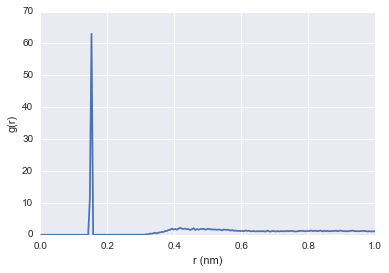

In [11]:
pairs = traj.top.select_pairs('name C', 'name C')
r, g_r = md.compute_rdf(traj, pairs)
plt.plot(r, g_r)
plt.xlabel('r (nm)')
plt.ylabel('g(r)')

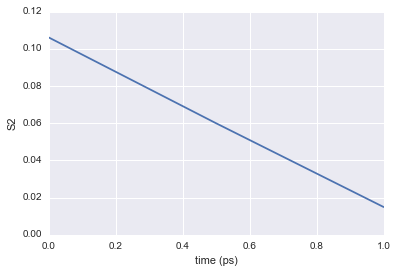

In [12]:
s2 = md.compute_nematic_order(traj, 'residues')
plt.plot(traj.time, s2)
plt.xlabel('time (ps)')
plt.ylabel('S2')